In [27]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.utils import shuffle
%matplotlib inline

## [SPSA method](https://en.wikipedia.org/wiki/Simultaneous_perturbation_stochastic_approximation)

SPSA is an algorithm used in numerical optimization.

Consider a loss function $L(\mathbf{x})$. In order to optimize $L$, SPSA iteratively optimizes the parameters of the loss function according to the following update rule:

$$\mathbf{y}_{n+1} = \mathbf{y}_{n} - a_{n}\widehat{\Delta L}_{n}(\mathbf{y}_{n}),$$

where $\widehat{\Delta L}_{n}(\mathbf{y}_{n}))$ is an estimate of the gradient at $\mathbf{y}_{n}$.

How SPSA calculates that gradient is by using a finite-difference rule on random perturbations of component of the parameter vector.
    $$\left( \widehat{\Delta L}_{n}(\mathbf{y}_{n}))\right)_{j} = \frac{L(\mathbf{y}_{n} + c_{n}\boldsymbol{\Delta}_{n}) - L(\mathbf{y}_{n} - c_{n}\boldsymbol{\Delta}_{n}) }{c_{n}\left(\boldsymbol{\Delta}_{n}\right)_{j}}$$
    
That is at each iteration, SPSA generates a random perturbation $\boldsymbol{\Delta}_{n}$, and does a finite-difference rule with that perturbation.

In order for the algorithm to converge, the random perturbation $\boldsymbol{\Delta}_{n}$ and finite-difference coefficients $c_{n}$ must satisfy certain properties (see the Wikipedia article linked to in the title). Importantly $c_{n}$ must tend to 0 as $n$ increases, and the size of the random fluctuations $\boldsymbol{\Delta}_{n}$ must also be bounded.

According to the wikipedia article, the coefficients $a_{n}$ and $c_{n}$ should look something like

$$c_{n} = \frac{c}{n^\gamma}~~\text{and}~~a_{n} = \frac{a}{n}.$$

In [2]:
def SPSA_gradient(loss, currentParams, gradientCoefficient):
    r'''Computes an estimator of the gradient using the procedure
    described in the SPSA algorithm.
    
    Inputs:
        loss: The loss function
        currentParams: The current value for the parameters
        gradientCoefficient: The coefficient c_n, which controls how much the current parameters are
                                               perturbed when computing the gradient
    
    Returns:
        gradient: The SPSA-based gradient of the loss function at currentParams'''
    
    numParams = len(currentParams)
    # Generate a random perturbation using the Rademacher distribution
    randomPerturbation = 2*np.random.binomial(1, .5, size=numParams) - 1
    
    gradient = (loss(currentParams + gradientCoefficient*randomPerturbation) - loss(currentParams - gradientCoefficient*randomPerturbation))\
                        /(gradientCoefficient*randomPerturbation)
    
    return gradient

def SPSA_update(loss, currentParams, updateCoefficient, gradientCoefficient):
    r'''Performs a parameter update according to the SPSA approach.
    
    NOTE: This function isn't aware of the notion of iterations, or anything of that sort.
    
    Inputs:
        loss: The loss function
        currentParams: The current value for the parameters
        updateCoefficient: The coefficient a_n, which controls how the current parameters are updated
                                            when including the gradient
        gradientCoefficient: The coefficient c_n, which controls how much the current parameters are
                                               perturbed when computing the gradient

    Returns:
        The updated parameter values'''
    
    grad = SPSA_gradient(loss, currentParams, gradientCoefficient)
    
    return currentParams - updateCoefficient*grad

# Example 1

Here's a simple example, where we use SPSA to minimize the loss function

$$L(\mathbf{x}) = \sum_{j}(\mathbf{x}_{j} - 1)^{2}.$$

That is, the optimal output is the all-ones vector.

In [3]:
def loss(x):
    r'''Compute the loss'''
    return np.linalg.norm(x - np.ones_like(x))

In [8]:
c = 2
a = 1

# Make some lists to keep track of things
lossList = []
coeffsList = []
paramsList = []

# Set starting values for the parameters
np.random.seed(0)
currentParams = np.random.uniform(size=4)

# Do the updates
for j in range(50):
    cj = c/(j+1)**.5
    aj = a/(j+1)

    lossList.append(loss(currentParams))
    coeffsList.append((cj, aj))
    paramsList.append(currentParams)
    
    currentParams = SPSA_update(loss, currentParams, aj, cj)
    


Let's plot how the loss changes, plus the update coefficients, to see what's going on.

Text(0.5, 1.0, 'Parameter values')

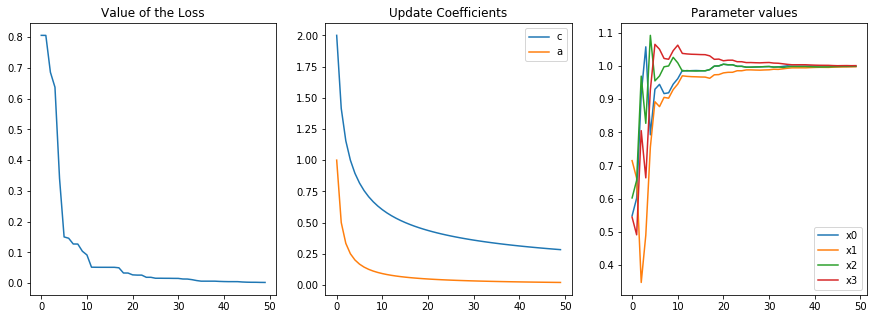

In [11]:
fig = plt.figure(figsize=(15, 5))

ax = fig.add_subplot(1, 3, 1)
ax.plot(lossList)
ax.set_title('Value of the Loss')

ax = fig.add_subplot(1, 3, 2)
ax.plot([X[0] for X in coeffsList], label='c')
ax.plot([X[1] for X in coeffsList], label='a')
ax.set_title('Update Coefficients')
ax.legend(loc=0)

ax = fig.add_subplot(1, 3, 3)
for j in range(4):
    ax.plot([X[j] for X in paramsList], label='x{0}'.format(j))
ax.legend(loc=0)
ax.set_title('Parameter values')

We see that the parameters converge to their optimal values of 1.

# Example 2: Training a support vector machine

This example will show how to train a [support vector machine](https://en.wikipedia.org/wiki/Support-vector_machine) using SPSA.

We will use a dataset that is used for our project.

In [14]:
data1Path = r'../dataset/data1a.txt'
data1Label = r'../dataset/data1alabel.txt'

dataCoords = np.loadtxt(data1Path)
dataLabels = np.loadtxt(data1Label)

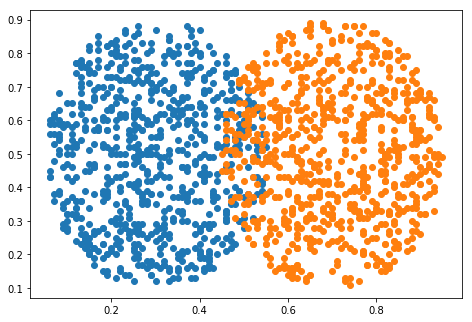

In [21]:
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])

ax.plot(np.ravel(dataCoords[np.where(dataLabels == 0)])[::2],
np.ravel(dataCoords[np.where(dataLabels == 0)])[1::2], ls='', marker='o')

ax.plot(np.ravel(dataCoords[np.where(dataLabels == 1)])[::2],
np.ravel(dataCoords[np.where(dataLabels == 1)])[1::2], ls='', marker='o')

A support vector machine will learn a hyperplane that separates this data.

Such a hyperplane has 3 parameters $(x,y,b)$, where $b$ is an offset.

In [30]:
def value(x, dataPoint):
    r'''Returns the value assigned to a datapoint by the SVM'''
    return np.dot(x[:2], dataPoint) - x[2]

def loss(x, dataPoint, dataLabel):
    r'''The loss function we'll use is the hinge loss'''
    return max(0, 1-dataLabel*value(x, dataPoint))

We'll use the idea of [mini-batching](https://machinelearningmastery.com/gentle-introduction-mini-batch-gradient-descent-configure-batch-size/) when doing this training. Instead of iterating over the full data set each time to compute the loss, we'll grab a random sample and use that instead.

In [41]:
# Make a data structure which is easier to work with
# for shuffling. 
# Also, notice we change the data labels from {0, 1} to {-1, +1}
data = list(zip(dataCoords, 2*dataLabels-1))
shuffled_data = shuffle(data)

In [67]:
c = 5
a = 1

# Make some lists to keep track of things
lossList = []
coeffsList = []
paramsList =[]
accuracyList = []

# Set starting values for the parameters
np.random.seed(2)
currentParams = np.random.uniform(size=3)

# Do the updates
for j in range(200):
    cj = c/(j+1)**.5
    aj = a/(j+1)
    
    # Grab a subset of the data for minibatching
    np.random.seed(j)
    data_ixs = np.random.choice(len(shuffled_data), size=len(shuffled_data))
    
    # Evaluate the loss over that subset
    # We include a regularization term at the end
    L = lambda x: np.sum([loss(x, shuffled_data[j][0], shuffled_data[j][1]) for j in data_ixs])/len(data_ixs) + .05*np.linalg.norm(x[:2])**2
    
    lossList.append(L(currentParams))
    coeffsList.append((cj, aj))
    paramsList.append(currentParams)
    accuracyList.append(np.sum([np.sign(value(currentParams,d[0])) == d[1] for d in data])/len(data))
    
    currentParams = SPSA_update(L, currentParams, aj, cj)

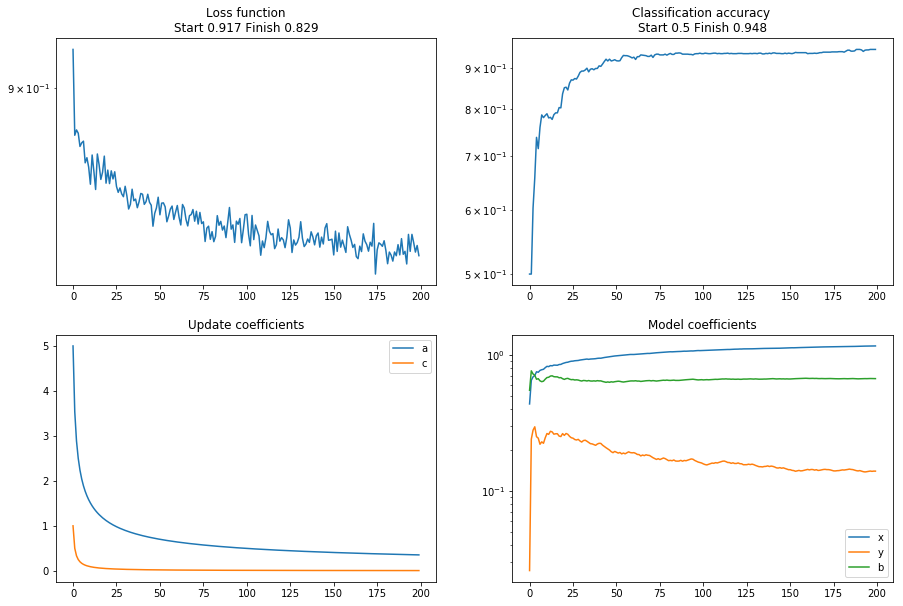

In [68]:
fig = plt.figure(figsize=(15, 10))

ax = fig.add_subplot(2, 2, 1)
ax.plot(lossList)
ax.set_title('Loss function\nStart {0} Finish {1}'.format(np.round(lossList[0], 3), np.round(lossList[-1], 3)))
ax.set_yscale('log')

ax = fig.add_subplot(2, 2, 2)
ax.plot(accuracyList)
ax.set_title('Classification accuracy \nStart {0} Finish {1}'.format(np.round(accuracyList[0], 3), np.round(accuracyList[-1], 3)))
ax.set_yscale('log')

ax = fig.add_subplot(2, 2, 3)
ax.plot([c[0] for c in coeffsList], label='a')
ax.plot([c[1] for c in coeffsList], label='c')
ax.legend(loc=0)
ax.set_title('Update coefficients')

ax = fig.add_subplot(2, 2, 4)
ax.plot([c[0] for c in paramsList], label='x')
ax.plot([c[1] for c in paramsList], label='y')
ax.plot([c[2] for c in paramsList], label='b')
ax.set_yscale('log')
ax.set_title('Model coefficients')
ax.legend(loc=0)

The loss goes down some, but not a whole heck of a lot.

We see that the model coefficient which corresponds to the y-coordinate of the data points doesn't really converge.
As we can see from the original data set itself, we don't actually need the y-corrdinate, so this really isn't a problem.

In [59]:
# A quick evaluation of the accuracy
np.sum([np.sign(value(currentParams,d[0])) == d[1] for d in data])/len(data)

0.9473333333333334

Below we plot values assigned to a grid overlaid on our data.

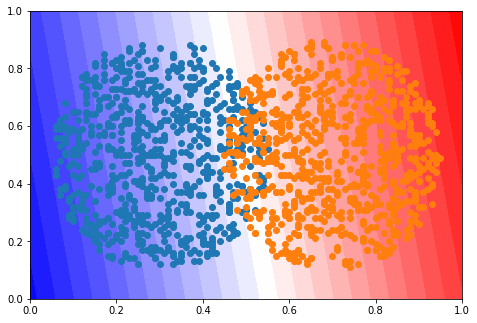

In [78]:
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
ax.plot(np.ravel(dataCoords[np.where(dataLabels == 0)])[::2],
np.ravel(dataCoords[np.where(dataLabels == 0)])[1::2], ls='', marker='o')

ax.plot(np.ravel(dataCoords[np.where(dataLabels == 1)])[::2],
np.ravel(dataCoords[np.where(dataLabels == 1)])[1::2], ls='', marker='o')

X = np.linspace(0, 1, num=100)
Z = np.zeros((len(X), len(X)))

# Contour map
for j in range(len(X)):
    for k in range(len(X)):
        # Fill Z with the labels (numerical values)
        # the inner loop goes over the columns of Z,
        # which corresponds to sweeping x-values
        # Therefore, the role of j,k is flipped in the signature
        Z[j, k] = value(currentParams, np.array([X[k], X[j]]))
        
ax.contourf(X, X, Z, cmap='bwr', levels=30)